In [1]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.spatial.distance import cdist
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


import sys, os
sys.path.append('../../Utils')
import model_utils as mutils
%load_ext autoreload
%autoreload 2

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime').drop(columns=['2657', '2828']) #DROPPING FAULTY SYSTEMS
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')

lats = dict(uk_pv.set_index('ss_id')['latitude_rounded'])
longs = dict(uk_pv.set_index('ss_id')['longitude_rounded'])

In [3]:
#DATA VARIABLES
# SYSTEMS_NUM = 50
# TIMESTEPS_NUM = int(len(data) / 5)
# TRAIN_FRAC = 0.9
# TEST_STATIONS = 40

#DATA VARIABLES
SYSTEMS_NUM = 400
TIMESTEPS_NUM = 500
TRAIN_FRAC = 0.9
TEST_STATIONS = 400

In [4]:
data_multiple = data.iloc[:, :SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()

capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked = mutils.stack_dataframe(data_multiple, lats, longs)

X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])

In [5]:
X_train, X_test, _, _, Y_train, Y_test = mutils.train_split_3d(t = X, R=None, Y = Y, train_frac = TRAIN_FRAC, split_by_day = False)


In [6]:
data_unseen = data.iloc[:, SYSTEMS_NUM:SYSTEMS_NUM+TEST_STATIONS][:TIMESTEPS_NUM + 60].reset_index()

capacities_unseen = uk_pv[uk_pv.ss_id_string.isin(data_unseen.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked_unseen = mutils.stack_dataframe(data_unseen, lats, longs)

del data,uk_pv

X_unseen = np.array(stacked_unseen[['epoch', 'longitude', 'latitude']])
Y_unseen = np.array(stacked_unseen[['PV']])


In [7]:
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_unseen_scaled =  X_scaler.transform(X_unseen)

In [8]:
nbrs = NearestNeighbors(n_neighbors=500, algorithm='ball_tree').fit(X_train_scaled)
distances_neighbours, idx_neighbours = nbrs.kneighbors(X_unseen_scaled)
values_neighbours = Y_unseen[:,0][idx_neighbours]

In [10]:
power = 2
c = 0.1 #smoothing parameter as described in https://spacetimewithr.org/Spatio-Temporal%20Statistics%20with%20R.pdf
weights = 1 / (distances_neighbours + 0.01)**2
norm_weights = weights / weights.sum(axis=1)[:, np.newaxis]
predictions = np.sum(norm_weights * values_neighbours, axis = 1)

Y_MW =  Y_unseen.reshape((TIMESTEPS_NUM + 60,TEST_STATIONS)) * capacities_unseen
predicted_MW = predictions.reshape((TIMESTEPS_NUM + 60,TEST_STATIONS)) * capacities_unseen
MAE = np.sqrt(np.nanmean((Y_MW - predicted_MW)**2))


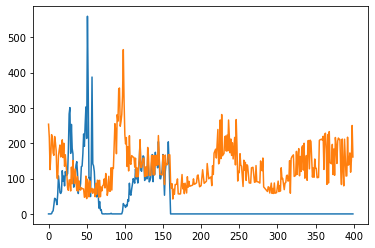

In [14]:
plt.plot( Y_MW[1,:500])
plt.plot(predicted_MW[1,:500])

In [ ]:
weights = (1 / distances)** power
norm_weights = weights / np.sum(weights, axis = (2,3))[:,:, np.newaxis, np.newaxis]
predictions = np.sum(norm_weights * Y_train[np.newaxis,np.newaxis,:,:], axis = (2,3))
Y_MW = Y_test * capacities_test
predicted_MW = predictions * capacities_test
MAE = np.sqrt(np.nanmean((Y_MW - predicted_MW)**2))

In [ ]:
data_multiple = data.iloc[:, :SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()

capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked = mutils.stack_dataframe(data_multiple, lats, longs)

X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])
#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)

#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_by_day = False)

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values


In [ ]:
data_unseen = data.iloc[:, SYSTEMS_NUM:SYSTEMS_NUM+TEST_STATIONS][:TIMESTEPS_NUM].reset_index()

capacities_unseen = uk_pv[uk_pv.ss_id_string.isin(data_unseen.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked_unseen = mutils.stack_dataframe(data_unseen, lats, longs)

del data,uk_pv

X_unseen = np.array(stacked_unseen[['epoch', 'longitude', 'latitude']])
Y_unseen = np.array(stacked_unseen[['PV']])

t, R_unseen, Y_unseen = bayesnewton.utils.create_spatiotemporal_grid(X_unseen, Y_unseen)

R_scaled_unseen = np.tile(R_scaler.transform(R_unseen[0]), (R_unseen.shape[0],1, 1)) #renormalise R and project across time



In [ ]:
time_scale = 20
X_unseen_scaled = X_unseen
X_unseen_scaled[:,0] = X_unseen[:,0] / time_scale

In [ ]:
distances_neighbours

In [ ]:
cdist(R_train_scaled[0], R_scaled_unseen[0])

In [ ]:
def evaluate_IDW(power, time_factor, t_train, R_train, Y_train, t_test, R_test, Y_test, capacities_test):
    '''
    Function that calculates the IWD prediction for a single helf out system
    power - power of distance metric
    time_factor - factor that governs the weighted sum between time and space dimension
    
    returns:
    - MAE of the predictor (averages over all systems)
    - prediction for that specific location and timestep
    
    '''
    
    #NEW VECTORIZED WAY
    space_distances = cdist(R_train, R_test)
    time_distances = time_factor * cdist(t_train, t_test) 

    batch_size = 1
    number_of_minibatches = int(len(time_distances) / batch_size)
    time_indices_batches = np.array_split(time_distances, number_of_minibatches)
    distances = np.add.outer(space_distances, time_indices_batches[0]).swapaxes(0,3)
    for mini_batch in range(1, number_of_minibatches):
        print(f'doing batch {mini_batch}')
        dist = np.add.outer(space_distances, time_indices_batches[mini_batch]).swapaxes(0,3)
        print(dist.shape)
        distances = np.append(distances, dist, axis = 2)
        
    del space_distances, time_distances
    weights = (1 / distances)** power
    del distances
    norm_weights = weights / np.sum(weights, axis = (2,3))[:,:, np.newaxis, np.newaxis]
    del weights
    predictions = np.sum(norm_weights * Y_train[np.newaxis,np.newaxis,:,:], axis = (2,3))
    del norm_weights
    Y_MW = Y_test * capacities_test
    predicted_MW = predictions * capacities_test
    MAE = np.sqrt(np.nanmean((Y_MW - predicted_MW)**2))
    
    return MAE, predictions

In [ ]:
power = 2
time_factor = 1/10
MAE, predictions = evaluate_IDW(power, time_factor, t_train, R_train_scaled[0], Y_train[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0], capacities_unseen)
